## Time Series Main Project

- 프로젝트 1,2는 정상적인 흐름대로

- 프로젝트 3에서 다양한 방법 시도 -> 기존의 결과와 비교 분석

- 다양한 방법 사용 -> 성능향상 시도

## 1. Data Labeling

- PCD, UMA, Local Min-Max, Trend Scanning 적용하기

In [1]:
## Packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='time'>

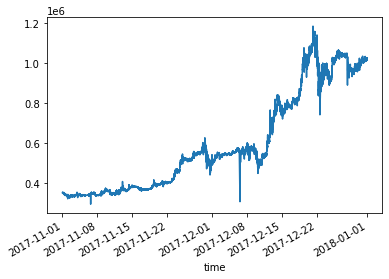

In [2]:
# 데이터 경로
DATA_PATH = '/aiffel/aiffel/fnguide/data/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

#### Price Change Direction

In [6]:
# Q. 코드를 작성해주세요 (노드대로 최대한 가자)

# window 지정 (그대로 10 기입)
window = 10 # 앞서 사용한 window의 값은 10입니다.


# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1) # modify_data['close'].shift(window)활용

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index) # 데이터 활용을 위해 pd.Series를 사용합니다.

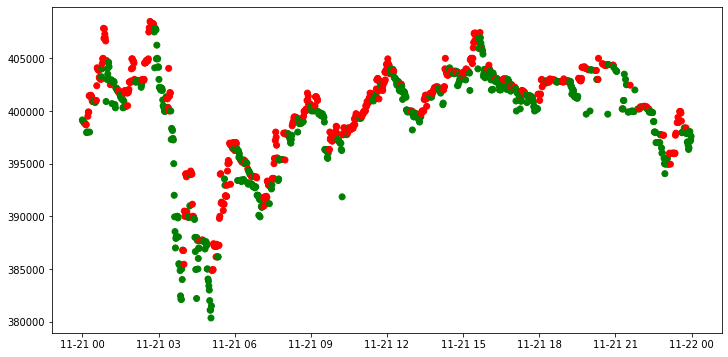

In [8]:
# Q. 코드를 작성해주세요 (노드대로 가보자)

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close'] # loc를 활용하여 2017-11-21부터 close(종가)까지 가져오기

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21'] # loc를 활용하여 2017-11-21의 시간대별 값을 가져오기

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'green') # np.where 사용

# 시각화하기
plt.figure(figsize=(12,6))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

## ..? 빨간색만 표시된다. -> 위에서 shift한 것을 빼주지 않아서 원 데이터만 출력
## 해결! -> 색을 바꿔보자

#### Using Moving Average

In [9]:
# Q. 코드를 작성해주세요 (노드대로!)

# momentum_signal 
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
# modify_data['close'].rolling(window).mean() 활용

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index) # pd.Series로 변환

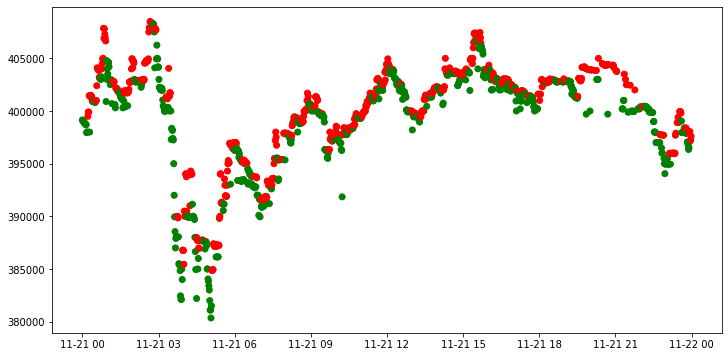

In [10]:
# Q. 코드를 작성해주세요

# 기존 데이터 만들기
#[[YOUR CODE]]
sub_data = modify_data.loc['2017-11-21', 'close']


# 수식 적용된 데이터 만들기
#[[YOUR CODE]]
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
#[[YOUR CODE]]
c_sig['color'] = np.where(c_sig == 1, 'red', 'green')


# 시각화하기
#[[YOUR CODE]]
plt.figure(figsize=(12,6))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])


#### Local Min-Max

In [12]:
# Q. 코드를 작성해주세요

# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0] #[[YOUR CODE]] # ① -> 초기값으로 설정 
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val # [[YOUR CODE]] # ② max값을 새로운 max값으로 변환
            maxes.append(max_value) # [[YOUR CODE]]  # ③ list에 추가 
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True # [[YOUR CODE]] # ④ 변경되었으므로 True 입력
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False # [[YOUR CODE]] # ⑤ 업데이트가 안됨을 표시
            n_cnt_max += 1 # [[YOUR CODE]] # ⑥ max가 변환된 횟수 추가
            if n_cnt_max >= wait:
                min_value = max_value # [[YOUR CODE]] # ⑦ max가 wait 이상을 초과..?
                # 여긴 이해가 잘 안되었다 ㅠ -> 기회가 되면 질문드리거나 피드백받자
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes}) 
# [[YOUR CODE]] # ⑧ min, max time을 dataframe으로 return

In [13]:
# Local mins, maxes를 확인 (노드대로 waits는 3으로 설정해준다.)
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인 
print(mins)
print('--'*20)
print(maxes)

## 겉보기엔 별 차이가..? (477, 273)의 shape을 얻었다.
## wait의 갯수만큼 shape의 갯수도 비례하겠지.

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

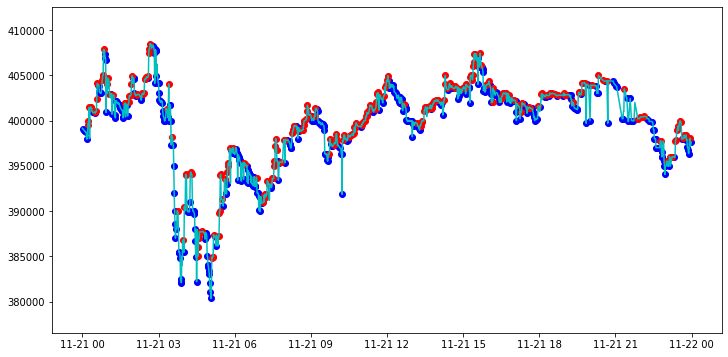

In [15]:
# Q. 코드를 작성해주세요

# subplots 및 plot 생성
fig, ax = plt.subplots(1, 1, figsize=(12, 6)) #[[YOUR CODE]]
ax.plot(sub_data, 'c')

# min_time, local_min을 활용한 scatter plot 생성
#[[YOUR CODE]]
ax.scatter(mins.min_time, mins.local_min, c='blue')

# maxes_time, local_max를 활용한 scatter plot 생성
#[[YOUR CODE]]
ax.scatter(maxes.max_time, maxes.local_max, c='red')

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

## 노드에서는 내가 임의로 wait를 2로 설정해서 촘촘했지만, 여기는 3으로 설정한 상태
## 그래서 조금 덜 촘촘해 보이는 것 같다.

#### Trend Scanning

In [16]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [17]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []
## 노드대로 가자!

In [18]:
# Q. 코드를 작성해주세요

# 이 코드 블럭은 실행에 20-30분정도가 소요될 수 있습니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
## 위의 for문은 후에 stepwise나 backward로 변형해서 사용할 수 있겠다.

    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [13:06<00:00, 42.43it/s]


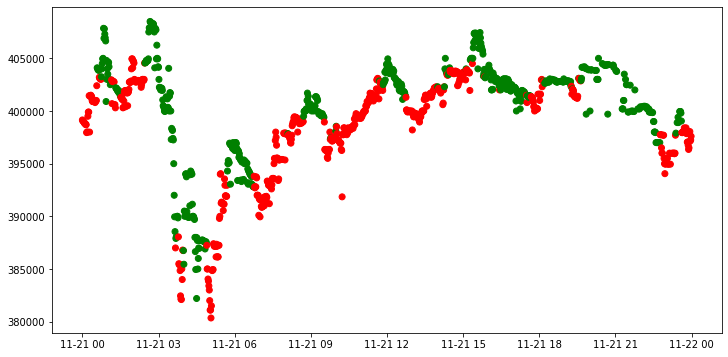

In [19]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'green')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

## 시간이 약 15분 정도 소요 (다른 것들은 1분 이내)
## 걸리는 만큼, 통계적인 유의성도 보장이 된다.

## 2. Feature Engineering

### 1. 환경구성 및 Data 불러오기

In [20]:
# !pip install ta==0.9.0
# !pip install shap

In [21]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [22]:
# 데이터 경로 설정
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

### 2. Technical Index 적용

In [23]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [24]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [25]:
# Q. 코드를 작성해주세요

df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1] #[[YOUR CODE]] # iloc[:, -1] 사용

# StandardScaler 적용
sc = StandardScaler() #[[YOUR CODE]]

# fit_transform 사용
X_sc = sc.fit_transform(X) #[[YOUR CODE]]

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [27]:
## 확인 (잘 됐군)
X_sc.head(10)

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.035464,-0.186753,0.065427,0.391695,0.143181,1.474065,0.054076,0.103695,0.930692,-0.078062,...,-0.141586,0.073599,-0.268825,-0.053926,-0.273922,-0.077989,-0.359687,0.617241,-0.335632,0.273404
2018-01-01 00:44:00,1.054026,0.125880,-0.011156,0.814123,0.544363,1.478520,0.017250,0.639945,0.771813,-0.051294,...,0.344922,1.111779,-0.209690,2.237163,-0.263511,0.036043,-0.266915,0.940844,-0.262646,0.291664
2018-01-01 00:45:00,1.042978,-0.023653,0.063195,1.052689,0.218332,1.290057,-0.020738,0.714133,0.598850,-0.015958,...,0.067032,0.544625,-0.124252,0.554780,-0.278339,0.150308,-0.252720,0.942325,-0.237456,0.301886
2018-01-01 00:46:00,1.016133,0.880060,-0.281931,0.928143,1.068429,1.633699,-0.020738,1.434675,0.454452,0.071047,...,0.783648,1.457839,0.168697,2.536405,-0.228841,0.833801,-0.227291,1.672326,-0.022928,0.256716
2018-01-01 00:47:00,0.893440,0.486864,-0.562722,-0.026395,0.862103,1.942977,0.088583,0.921217,0.319680,0.131133,...,-0.191611,-0.257415,-0.080204,0.402681,-0.380178,0.036276,-0.340320,0.454122,-0.018291,0.317671
2018-01-01 00:48:00,1.153912,0.399649,-0.356489,0.395987,-0.427802,1.515597,0.155902,0.550784,0.169150,0.170007,...,-0.191611,-0.257415,-0.279243,0.098173,-0.392666,0.036276,-0.352232,0.698388,-0.018291,0.381363
2018-01-01 00:49:00,1.081741,0.365233,-0.589510,0.092547,-0.013864,1.323427,0.234874,0.359207,-0.019889,0.197103,...,-0.115095,-0.114477,-0.195704,-0.660464,-0.297523,1.184275,-0.301830,0.535105,-0.013101,0.290061
2018-01-01 00:50:00,0.894829,0.293222,-0.237468,0.396422,-0.013864,1.022160,0.289607,0.214532,-0.150214,0.214421,...,-0.115095,-0.114477,-0.075957,-0.205716,-0.015607,0.264805,-0.310749,0.616418,-0.003609,0.271032
2018-01-01 00:51:00,0.407790,0.300142,-0.505224,0.487550,0.025130,0.879333,0.327186,0.321382,-0.228045,0.238007,...,0.131207,0.314337,-0.279542,-1.262665,-0.251199,0.952255,-0.377213,-0.193743,0.026140,0.292676


In [28]:
# Q. 코드를 작성해주세요

# RandomForest 모델 적용
rfc = RandomForestClassifier(class_weight = 'balanced') #[[YOUR CODE]]

# RandomForest fit 하기
rfc.fit(X_sc, y) #[[YOUR CODE]]

RandomForestClassifier(class_weight='balanced')

### 3. Feature Selection methods 적용

In [29]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.048043,0.002347
volume_fi,0.041517,0.002154
volume_mfi,0.049079,0.002646
volume_sma_em,0.037012,0.001896
volume_vpt,0.024469,0.001524
volatility_atr,0.080240,0.003690
volatility_ui,0.047097,0.002557
trend_macd_diff,0.077890,0.003887
trend_adx,0.047567,0.002124
trend_trix,0.070550,0.002987


In [30]:
# MDA, Mean Decrease Accuracy
# svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
## Gradient Boosting Classifier 사용
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

cv = KFold(n_splits=10) # n_splits을 변경해봅시다. -> 5에서 10으로 
feat_imp_mda = imp.mean_decrease_accuracy(gbc, X_sc, y, cv_gen=cv)

In [31]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

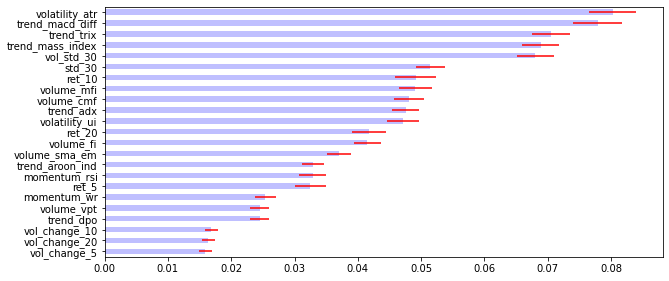

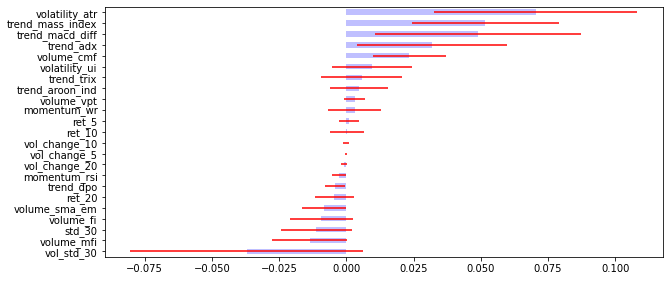

In [33]:
# Q. 코드를 작성해주세요 (노드대로!)

# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

## MDA의 일부 feature는 매우 큰 표준편차를 보였다.
## 양수와 음수의 지표는 거의 반반으로 비슷했다.

In [34]:
# Q. 코드를 작성해주세요

# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True)

# gbc = GradientBoostingClassifier() 이거 써도 되나..? -> 위에서는 바꿨는데
rfe_cv = RFECV(svc_rbf, cv=cv) #[[YOUR CODE]] # RFECV
rfe_fitted = rfe_cv.fit(X_sc, y) #[[YOUR CODE]] # fit

In [35]:
# 선택된 피처 확인
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,14
volume_fi,False,6
volume_mfi,False,16
volume_sma_em,False,9
volume_vpt,False,10
volatility_atr,False,2
volatility_ui,False,13
trend_macd_diff,True,1
trend_adx,False,21
trend_trix,False,12


In [37]:
rfe_df[rfe_df["Optimal_Features"]==True] # True가 있나 -> 1개뿐이다

,Optimal_Features,Ranking
trend_macd_diff,True,1


In [38]:
# SFS, Sequential Feature Selection

# n = [Your Code] 노드에서는 2였는데, 4로 높여보자 
# 선택된 feature 수 증가 -> 모델 더 복잡, 과적합 가능성 늘어남 but 성능향상 기대
n = 4
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [39]:
# 선택된 feature 확인
sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns={"Optimal_Features"})

sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff', 'trend_adx', 'trend_dpo'], dtype='object')

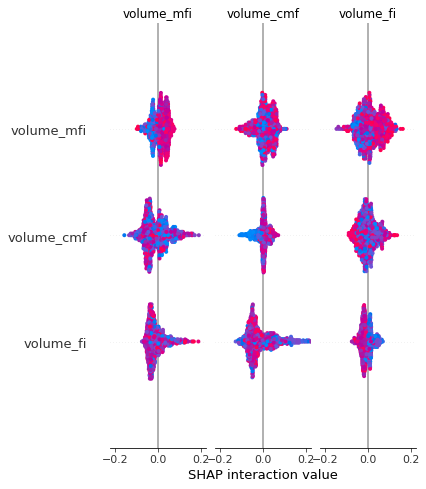

In [40]:
# Q. 코드를 작성해주세요

# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
#[[YOUR CODE]]
shap.summary_plot(shap_value, X_sc)

In [41]:
## 해당 그래프 해석하는 방법 좀 알고싶다..!!!!
## 눈으로만 봐선 뭐가 좋은지 모르겠다.

## 3. Model Training

### 1. 환경구성 및 Data 불러오기

In [42]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [128]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

# 이 부분을 노드는 빠진 것 같다.
df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2 # 노드와 다르게 65%, 25%로 변경
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
# 표본을 더 늘리고 싶은데 엄청난 시간 소요를 이유로 생략..
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

### 2. Purged K-fold for Cross-Validation 적용

In [150]:
# Q. 코드를 작성해주세요

n_cv = 7 #[[YOUR CODE]] # 앞에서 지정한 값은 4입니다. 얼마를 넣을지 생각해보고 왜 이 값을 넣었는지에 대해서 설명해봅시다.
t1 = pd.Series(train_y.index.values, index=train_y.index)
## k-fold개의 집합은 너무 많아도 시간이 오래 걸린다. 적당한 개수이자 4보다 큰 7로 설정. 

# purged K-Fold 
cv = PKFold(n_cv, t1, 0) #[[YOUR CODE]] 이번에는 purging window 크기 입력

### 3. Model 적용

In [151]:
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요(randomforest)
bc_params = {'n_estimators': [3, 5, 10],
             'max_features': [0.3, 0.5, 0.7],
             'base_estimator__max_depth': [3,5,10],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [5, 10, 15],
             'bootstrap_features': [False, True]
            }

In [137]:
# hyper parameter tuning(xgboost) -> 사용 불가 
# bc_params = {
#    'n_estimators': [3, 5, 10], # Boosting 반복횟수
#    'learning_rate': [0.01, 0.1], # 학습률
#    'max_depth': [3, 5, 10], # Tree 최대깊이
#    'min_child_weight': [1, 3, 5], # 과적합 방지용 파라미터
#    'gamma': [0, 0.1, 0.2], # 트리 노드 분할할 최소 손실감소 값
#    'subsample': [0.8, 1.0], # 각 Boosting 반복에 사용할 샘플의 비율
#    'colsample_bytree': [0.8, 0.9, 1.0] # 각 트리 구성 시 사용할 Feature 비율
# }

In [152]:
# XGBoost 사용
# from xgboost import XGBClassifier
# xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [153]:
rfc = RandomForestClassifier(class_weight='balanced')

In [154]:
bag_rfc = BaggingClassifier(rfc)

In [155]:
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

In [156]:
## XGBoost 오류난다 ㅠㅠ index 1142 is out of bounds for axis 0 with size 1000
## 그래서 RandomForest에 parameter tuning 계수만 조정했다.
## purging windows가 1일땐 위와 같은 오류가 떴는데? 0으로 하니까 안뜬다.
## 다시 xgb가 될까? -> 튜닝 리스트 중 뭔가 잘못된 오류가 떴다.
## 그래서 계수 조정만 한 RandomForest 쓰기로..(오류 분석하느라 20분 소요)
gs_rfc.fit(train_x, train_y)
gs_rfc_best = gs_rfc.best_estimator_

Fitting 7 folds for each of 324 candidates, totalling 2268 fits


In [158]:
## best estimator (위의 소요시간이 만만치않다)
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=3,
                                                        min_samples_leaf=5),
                  max_features=0.3, n_estimators=3)

In [159]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [160]:
# Q. 코드를 작성해주세요

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y) 

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[254 148]
 [ 88 101]]
정확도:0.6006768189509306, 정밀도:0.40562248995983935, 재현율:0.5343915343915344


auc:0.5831161652057175


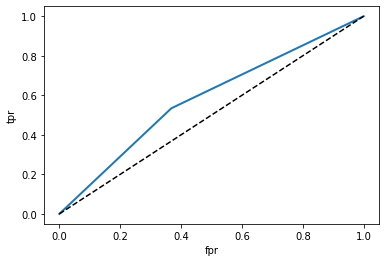

In [161]:
# Q. 코드를 작성해주세요

# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, pred_y) #[[YOUR CODE]]
auc = roc_auc_score(test_y, pred_y) #[[YOUR CODE]]

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

In [ ]:
## 생각보다 tuning 과정에서 시간소요가 많이 되어서 여러 가지 변수 변경하는 시도는 해보지 못했다.
## 앞에 표본 갯수를 늘리면 기하급수적으로 parameter tuning과정 시간이 늘어났다.
## 그래서 표본 갯수 조정은 앞의 연습과정에서 진행 후 여기서는 그대로 했다.
## 표본을 늘려도 AUC 값은 오히려 감소해서 적당한 표본 수가 좋은 것 같다.
## 오후 6시8분 -> 결국 감소했다 ㅠㅠ